# 01-01: Data Preparation

The basic idea is to create a sequential recommendation system in Keras by combining Convolutional Neural Networks (CNNs) with Recurrent Neural Networks (RNNs) for sequence prediction.

Before applying deep learning models, preprocessing the sequence data is necessary. This involves tokenizing the sequences and possibly using techniques like padding to ensure that all input sequences have the same length. For your dataset, you might consider each session as a sequence and each item interaction within a session as a token within that sequence.

## References

- https://github.com/sonyisme/keras-recommendation
- https://github.com/Gaurav7888/RecSys/blob/0789c74b85609957a8609900b29cb812d4960356/Recommendation_system_using_NCF.ipynb#L1530
- https://microsoft-recommenders.readthedocs.io/en/latest/index.html
- https://github.com/recommenders-team/recommenders/tree/main


In [1]:
# import os
# os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/usr/local/cuda-12.2"
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Dense
from keras.optimizers import Adam

import tensorflow as tf
import tensorflow_recommenders as tfrs

2024-03-01 15:23:32.432102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 15:23:32.432130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 15:23:32.433040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 15:23:32.437752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 15:23:32.914440: W tensorflow/compiler/tf2

## 1. Dataset Description

- Describe the dataset in detail: sources, features, and statistics.
- Discuss any limitations or biases present in the dataset.

In [3]:
data_path = '../../data/coveo'
model_path = '../../models/coveo'

# file paths for the data files
train_path = f'{data_path}/coveo_processed_view_train_tr.tsv'
validation_path = f'{data_path}/coveo_processed_view_train_valid.tsv'
test_path = f'{data_path}/coveo_processed_view_test.tsv'

In [4]:
# load the datasets
df_train = pd.read_csv(train_path, sep='\t').sample(frac=0.3, random_state=42)
df_validation = pd.read_csv(validation_path, sep='\t')
df_test = pd.read_csv(test_path, sep='\t')

In [5]:
# show the shape of the datasets
print('Train      :', df_train.shape)
print('Validation :', df_validation.shape)
print('Test       :', df_test.shape)

Train      : (410401, 3)
Validation : (43032, 3)
Test       : (52501, 3)


In [6]:
# head of the training set
display(df_train.head())

,SessionId,ItemId,Time
893300,289617,245,1544683595406
1132153,367012,3407,1545128579533
541990,176670,672,1545115848623
986245,320058,6906,1544647058411
207069,67818,3860,1544427818298


In [7]:
# unique sessions in each dataset
print('Train      :', df_train.SessionId.nunique())
print('Validation :', df_validation.SessionId.nunique())
print('Test       :', df_test.SessionId.nunique())

Train      : 126180
Validation : 5905
Test       : 7748


In [8]:
# average session length in each dataset
print('--- Train ---')
print(df_train.groupby('SessionId').size().describe())
print('--- Validation ---')
print(df_validation.groupby('SessionId').size().describe())
print('--- Test ---')
print(df_test.groupby('SessionId').size().describe())

--- Train ---
count    126180.000000
mean          3.252504
std           3.693615
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         145.000000
dtype: float64
--- Validation ---
count    5905.000000
mean        7.287384
std         8.974551
min         2.000000
25%         3.000000
50%         4.000000
75%         8.000000
max       134.000000
dtype: float64
--- Test ---
count    7748.000000
mean        6.776071
std         8.341588
min         2.000000
25%         2.000000
50%         4.000000
75%         8.000000
max       146.000000
dtype: float64


## 2. Data Preprocessing

- Detail the preprocessing steps with explanations for each decision.
- Show visualizations of data distribution, session lengths, and item frequencies.

In [9]:
# convert the items ids to strings
df_train['ItemId'] = df_train['ItemId'].astype(str)
df_validation['ItemId'] = df_validation['ItemId'].astype(str)
df_test['ItemId'] = df_test['ItemId'].astype(str)

### 2.1 Sequence Creation

The first step involves creating sequences of item interactions for each session. This requires grouping the data by SessionId and ordering it within each group based on the Time column. Each sequence represents a series of item interactions within a session.

In [10]:
# Sort by SessionId and Time to ensure the order is correct
df_train_sorted = df_train.sort_values(by=['SessionId', 'Time'])
df_validation_sorted = df_validation.sort_values(by=['SessionId', 'Time'])
df_test_sorted = df_test.sort_values(by=['SessionId', 'Time'])

# Create sequences of ItemIds grouped by SessionId
train_sequences = df_train_sorted.groupby('SessionId')['ItemId'].apply(list)
validation_sequences = df_validation_sorted.groupby('SessionId')['ItemId'].apply(list)
test_sequences = df_test_sorted.groupby('SessionId')['ItemId'].apply(list)

In [11]:
train_sequences.head(5)

SessionId
2                      [3]
13                    [10]
14                    [12]
18    [21, 22, 23, 27, 32]
21            [39, 41, 44]
Name: ItemId, dtype: object

In [12]:
# drop the sessions with only one item
train_sequences = train_sequences[train_sequences.map(len) > 1]
train_sequences.head(5)

SessionId
18                                [21, 22, 23, 27, 32]
21                                        [39, 41, 44]
23                        [60, 61, 62, 68, 71, 75, 76]
24                                    [81, 83, 85, 90]
29    [92, 75, 104, 106, 108, 114, 116, 120, 123, 124]
Name: ItemId, dtype: object

### 2.2 Tokenization (Categorical Features Encoding)

We need to ensure that ItemIds are treated as categorical inputs.

Create a tokenizer to encode ItemIds as integers, 0 and 1 are special values, where 0 should be for padding and 1 for out of vocabulary items.

In [13]:
# get a list of the unique item ids across all datasets
unique_items = pd.concat([df_train, df_validation, df_test]).ItemId.unique()

# use keras to map the item ids to a sequential list of integer values,
# 0 should be for padding and 1 for out of vocabulary items
tokenizer = Tokenizer(num_words=len(unique_items) + 2, oov_token=1)
tokenizer.fit_on_texts(unique_items)

# save the tokenizer
tokenizer_path = f'{model_path}/item_id_tokenizer.json'
with open(tokenizer_path, 'w') as file:
    file.write(tokenizer.to_json())

In [14]:
# tokenize the sequences
train_sequences_tokenized = tokenizer.texts_to_sequences(train_sequences)
validation_sequences_tokenized = tokenizer.texts_to_sequences(validation_sequences)
test_sequences_tokenized = tokenizer.texts_to_sequences(test_sequences)

In [15]:
train_sequences_tokenized[:5]

[[2347, 7574, 3524, 5144, 8165],
 [6623, 2276, 361],
 [2691, 477, 897, 1123, 2085, 138, 6540],
 [449, 1368, 921, 109],
 [1835, 138, 1830, 399, 1607, 2739, 4738, 4466, 5417, 1156]]

### 2.3 Padding

To handle sessions of varying lengths, we'll need to pad the sequences so that they all have the same length, making them suitable for batch processing.

In [16]:
# use the last item as the target and the rest as the input
def split_input_target(sequence):
    return sequence[:-1], sequence[-1]

train_sequences_input = list(map(split_input_target, train_sequences_tokenized))
validation_sequences_input = list(map(split_input_target, validation_sequences_tokenized))
test_sequences_input = list(map(split_input_target, test_sequences_tokenized))

In [17]:
train_sequences_input[:5]

[([2347, 7574, 3524, 5144], 8165),
 ([6623, 2276], 361),
 ([2691, 477, 897, 1123, 2085, 138], 6540),
 ([449, 1368, 921], 109),
 ([1835, 138, 1830, 399, 1607, 2739, 4738, 4466, 5417], 1156)]

In [18]:
# separate into input and target arrays
train_input, y_train = map(list, zip(*train_sequences_input))
validation_input, y_validation = map(list, zip(*validation_sequences_input))
test_input, y_test = map(list, zip(*test_sequences_input))

In [19]:
pprint(train_input[:5])
print('-'*10)
pprint(y_train[:5])

[[2347, 7574, 3524, 5144],
 [6623, 2276],
 [2691, 477, 897, 1123, 2085, 138],
 [449, 1368, 921],
 [1835, 138, 1830, 399, 1607, 2739, 4738, 4466, 5417]]
----------
[8165, 361, 6540, 109, 1156]


In [20]:
# Determine the maximum sequence length for padding
#max_sequence_length = max(map(len, train_input))
max_sequence_length = 10

# pad the sequences
X_train = pad_sequences(train_input, maxlen=max_sequence_length, padding='post')
X_validation = pad_sequences(validation_input, maxlen=max_sequence_length, padding='post')
X_test = pad_sequences(test_input, maxlen=max_sequence_length, padding='post')

In [21]:
X_train[:5]

array([[2347, 7574, 3524, 5144,    0,    0,    0,    0,    0,    0],
       [6623, 2276,    0,    0,    0,    0,    0,    0,    0,    0],
       [2691,  477,  897, 1123, 2085,  138,    0,    0,    0,    0],
       [ 449, 1368,  921,    0,    0,    0,    0,    0,    0,    0],
       [1835,  138, 1830,  399, 1607, 2739, 4738, 4466, 5417,    0]],
      dtype=int32)

## 3. Model Architecture

In [22]:
model = Sequential()

2024-03-01 15:23:35.895073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 15:23:35.923676: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 15:23:35.923860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### 3.1 Embedding Layers

Embedding layers transform sparse, integer-encoded data into dense vectors of fixed size. This is particularly useful for categorical data with many categories, where one-hot encoding would result in vectors that are mostly zeros and inefficient both in terms of memory and computation. Embeddings capture more information per byte and allow the model to learn relationships between categories (in this case, ItemIds).

**Why It Is Done:**

Dimensionality Reduction: Embeddings reduce the dimensionality of the categorical data, representing items in a more compact and dense vector space.
Semantic Representation: The dense vectors obtained from embeddings can capture semantic relationships between items, such as similarity in user interaction patterns, which is not possible with one-hot encoding or similar techniques.
Improved Learning: By learning an optimal representation of items in a lower-dimensional space, embeddings can improve the model's performance on the recommendation task.
Implementation

In [23]:
max_item_id = max(tokenizer.index_word.keys())  # get the maximum item id from the tokenizer
embedding_dim = 64                              # Size of the embedding vectors

# Embedding layer for vectorizing ItemIds into dense vectors
model.add(Embedding(input_dim=max_item_id + 1, output_dim=embedding_dim, input_length=max_sequence_length))

## 3.2 CNN Layers

CNNs, particularly 1D CNNs (Conv1D), are adept at recognizing local patterns within sequences. The key advantage of using CNNs in sequence data processing is their ability to apply the same transformation across different parts of a sequence, making them translation invariant. This means that if a CNN learns a particular pattern (e.g., a specific sequence of item interactions) at one point in a session, it can recognize the same pattern at a different point, enhancing the model's ability to understand user behavior across sessions.

**Why It Is Done:**

- **Local Pattern Recognition**: CNNs excel at identifying patterns within localized regions of the input data. For sequence data, this means recognizing specific sequences of item interactions that are indicative of broader user preferences.
Translation Invariance: The ability of CNNs to recognize patterns regardless of their position in the sequence is particularly valuable for session-based recommendation systems, where the order of interactions can vary significantly across sessions.

- **Efficiency and Scalability**: CNNs can process data more efficiently than fully connected networks, especially for large datasets. This efficiency makes them suitable for handling the vast amounts of data typically involved in recommendation systems.

In [24]:
# Conv1D + MaxPooling1D for local pattern recognition and dimensionality reduction
#model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(5))

# Additional Conv1D + GlobalMaxPooling1D for deeper pattern recognition
#model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

#model.add(GlobalMaxPooling1D())

## 3.3  Recurrent Neural Network Layers

Incorporating Recurrent Neural Networks (RNNs) for sequence modeling into a deep learning architecture that already includes Convolutional Neural Networks (CNNs) layers is a strategic approach to handle sequence data effectively, especially for tasks like sequential recommendation systems. This combination leverages the strengths of both CNNs and RNNs, where CNNs excel in extracting local and position-invariant features, and RNNs are adept at capturing temporal or sequential dependencies.

The primary purpose of incorporating RNN layers after CNN layers is to model the temporal or sequential dependencies in the data. While CNNs are excellent for reducing a long sequence into a shorter one with extracted features (as mentioned in the document context about processing long sequences with CNNs before RNNs), they do not inherently understand the order or sequence of these features. RNNs, with their internal state and loop mechanism, can take the sequence of extracted features and learn patterns over time, making them ideal for tasks where the sequence order matters, such as predicting the next item in a session.

The CNN layers act as a preprocessing step that transforms the raw sequence data into a higher-level, downsampled representation. This transformation is crucial because it allows the RNN layers to process the data more efficiently by focusing on the most relevant features extracted by the CNNs. The RNN can then model the temporal dynamics of these features across the sequence. This setup is particularly beneficial for handling sequences that are too long to be processed directly by RNNs, as it reduces the sequence length and complexity before reaching the RNN layers.

RNNs are specifically designed to handle sequence data, making them a natural choice for sequence modeling tasks. They can maintain information about previous states or inputs through their hidden states, allowing them to make predictions based on the entire history of a sequence. This capability is crucial for understanding the context in sequential recommendation systems, where the relevance of an item can depend on the items that were interacted with previously.

In [25]:
#model.add(LSTM(32))  # LSTM layer with 32 units. Adjust the number of units based on your dataset and complexity.

## 3.4 Output Layer

The output layer of a sequential recommendation system is crucial as it directly influences the system's ability to make accurate and relevant recommendations. The design of this layer depends on the specific task at hand – in the case of a sequential recommendation system, the task is typically to predict the next item(s) a user is likely to interact with, based on their previous interactions within a session.

Given the sequential nature of the data, where the order of interactions matters significantly, the output layer must capture and utilize the rich representations learned by the preceding layers (embedding, CNNs for local pattern recognition, and RNNs for capturing temporal dynamics) to make these predictions.

### How It Relates to Preceding Layers:
The output layer receives processed and transformed data from the previous layers, which have worked in tandem to encode the input sequences into a meaningful representation that captures both the content and context of user interactions. The embedding layer first converts item IDs into dense vectors, capturing similarity and relationships between items. The CNN layers then extract local patterns within these embeddings, and the RNN layers model the sequential dependencies. The output layer must leverage this rich representation to make accurate predictions.

### Output Layer Design for Recommendation System:
For a sequential recommendation system, the output layer often uses a softmax activation function. This function is suitable because it can output a probability distribution over the set of possible items, indicating the likelihood of each item being the next interaction. This approach requires the output layer to have as many units as there are unique items in the dataset, with each unit corresponding to a specific item.

### Practical Use in Recommendation Systems:
In practice, the output of the model can be used to rank items based on their predicted likelihood of being the next user interaction. The system can then recommend the top-N items with the highest probabilities. This method allows for personalized recommendations that adapt based on the user's current session activities.

In [26]:
# temporary test, flatten the output
model.add(GlobalMaxPooling1D())

In [27]:
# Output layer for predicting the next item in the sequence
model.add(Dense(max_item_id+1, activation='softmax'))

## 3.5 Evaluation Metrics

It is important to establish a robust evaluation protocol and optimizing model performance, we'll focus on implementing and optimizing for the metrics Recall@K and MRR@K (Mean Reciprocal Rank at K). These metrics are particularly relevant for recommendation systems and ranking problems, where the goal is to accurately predict and rank a set of items in order of relevance.

### Evaluation Metrics: Recall@K and MRR@K

**Recall@K** measures the fraction of relevant items that are retrieved among the top-K recommendations. It's crucial for assessing the model's ability to capture the most relevant items within the first K suggestions.

**MRR@K** (Mean Reciprocal Rank at K) focuses on the rank of the first relevant item, averaging this metric over multiple queries. It's valuable for understanding how well the model ranks the first relevant item, emphasizing the importance of items ranked closer to the top.

Rational for Choosing Recall@K and MRR@K

- Recall@K is essential for ensuring that the top-K recommendations contain items truly relevant to the user, enhancing user satisfaction and engagement.
- MRR@K complements Recall@K by ensuring that not only are relevant items included in the top-K recommendations, but they are also ranked as high as possible.
Implementation

Given the emphasis on hyperparameter optimization and model evaluation, we'll implement custom functions for Recall@K and MRR@K and integrate them into the model training and evaluation process. This approach allows us to directly optimize and evaluate the model based on metrics that align closely with our objectives.

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 64)            693440    
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10835)             704275    
                                                                 
Total params: 1397715 (5.33 MB)
Trainable params: 1397715 (5.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4. Model Training

In [29]:
y_train_categorical = to_categorical(y_train, num_classes=max_item_id+1)
y_validation_categorical = to_categorical(y_validation, num_classes=max_item_id+1)

In [30]:
# Train the model
history = model.fit(X_train, y_train_categorical,
                    epochs=20,  # Number of epochs to train for
                    batch_size=128,  # Batch size
                    validation_data=(X_validation, y_validation_categorical))

Epoch 1/20


2024-03-01 15:23:44.155227: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc61c2b5f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 15:23:44.155244: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-03-01 15:23:44.159411: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-01 15:23:44.170971: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709299424.233436  140193 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


634/634 [==============================] - 16s 25ms/step - loss: 8.9527 - val_loss: 8.7428
Epoch 2/20
634/634 [==============================] - 5s 8ms/step - loss: 8.6838 - val_loss: 8.6539
Epoch 3/20
634/634 [==============================] - 4s 7ms/step - loss: 8.5947 - val_loss: 8.6094
Epoch 4/20
634/634 [==============================] - 4s 7ms/step - loss: 8.5158 - val_loss: 8.5810
Epoch 5/20
634/634 [==============================] - 4s 6ms/step - loss: 8.4419 - val_loss: 8.5653
Epoch 6/20
634/634 [==============================] - 4s 7ms/step - loss: 8.3650 - val_loss: 8.5556
Epoch 7/20
634/634 [==============================] - 4s 6ms/step - loss: 8.2793 - val_loss: 8.5423
Epoch 8/20
634/634 [==============================] - 4s 6ms/step - loss: 8.1822 - val_loss: 8.5289
Epoch 9/20
634/634 [==============================] - 4s 6ms/step - loss: 8.0737 - val_loss: 8.5208
Epoch 10/20
634/634 [==============================] - 4s 6ms/step - loss: 7.9529 - val_loss: 8.5197
Epoch 11

### 4.1 Plot training and validation loss

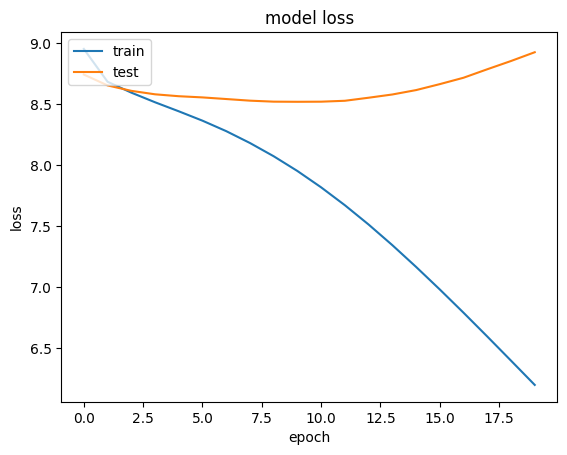

In [31]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [32]:
y_pred = model.predict(x=X_validation)
y_pred

185/185 [==============================] - 0s 440us/step


array([[1.16872227e-08, 1.15549188e-08, 1.31911074e-04, ...,
        1.14994148e-08, 1.10698846e-08, 1.20166703e-08],
       [1.24210139e-11, 1.24685600e-11, 3.38462960e-05, ...,
        1.30885892e-11, 1.24128910e-11, 1.22441059e-11],
       [2.47293030e-07, 2.53257355e-07, 1.52265769e-04, ...,
        2.53724664e-07, 2.49492501e-07, 2.48616260e-07],
       ...,
       [7.82369902e-09, 8.23658119e-09, 6.34709068e-05, ...,
        7.94665489e-09, 8.01056199e-09, 7.87267052e-09],
       [1.13517272e-14, 9.94479699e-15, 2.88629162e-05, ...,
        1.08387141e-14, 1.04332750e-14, 1.12991917e-14],
       [5.68367456e-13, 5.18707093e-13, 1.43402585e-05, ...,
        5.52353573e-13, 5.76902892e-13, 5.35513636e-13]], dtype=float32)

In [33]:
print(len(y_pred[0]))
print(len(y_validation_categorical[0]))

print(y_validation_categorical[0])
print(y_pred[0])

print(y_validation[0])
print(y_validation_categorical[0].argmax())
print(y_pred[0].argmax())

10835
10835
[0. 0. 0. ... 0. 0. 0.]
[1.1687223e-08 1.1554919e-08 1.3191107e-04 ... 1.1499415e-08 1.1069885e-08
 1.2016670e-08]
309
309
1244


In [34]:
item = 0
k = 20

print(f'Predicted: {y_pred[item].argmax()}')
print(f'Actual: {y_validation[item]}')

print(tf.nn.top_k(y_pred[item], k=k))

Predicted: 1244
Actual: 309
TopKV2(values=<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.00883235, 0.00865046, 0.00520542, 0.00511695, 0.00474807,
       0.00458925, 0.00446253, 0.00445797, 0.00386741, 0.0038591 ,
       0.00380647, 0.00373803, 0.00364476, 0.00356919, 0.00349397,
       0.00341679, 0.00338389, 0.00331361, 0.00320709, 0.00312078],
      dtype=float32)>, indices=<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([1244,  267, 1118,  322, 1099, 1120, 2095,  220,  839, 1567, 5783,
       4273,  907, 5708, 1023, 1701, 2239, 3372,  653, 3507], dtype=int32)>)


In [35]:
top_k_indices = tf.nn.top_k(y_pred, k=k).indices.numpy()
top_k_indices

array([[1244,  267, 1118, ..., 3372,  653, 3507],
       [ 586,  242,  237, ...,  342,  157, 1814],
       [ 237,  254,  157, ..., 1287, 4674, 1470],
       ...,
       [ 556, 3718, 2470, ..., 2020, 6710, 4648],
       [ 787, 2992,  430, ..., 1715, 1113, 1155],
       [6674, 6083, 3777, ..., 1114,   35, 5653]], dtype=int32)

In [36]:
# Expand dims of y_validation to match top_k_indices for broadcasting
y_validation_expanded = np.expand_dims(y_validation, axis=1)
y_validation_expanded

array([[ 309],
       [8701],
       [1146],
       ...,
       [3996],
       [1059],
       [4953]])

In [37]:
# Check if the true labels are in the top-k predictions
correct_predictions = np.any(top_k_indices == y_validation_expanded, axis=1)

# Calculate Recall@k
recall_at_k = np.mean(correct_predictions)
print(f'Recall@{k}: {recall_at_k}')

Recall@20: 0.07874682472480948
